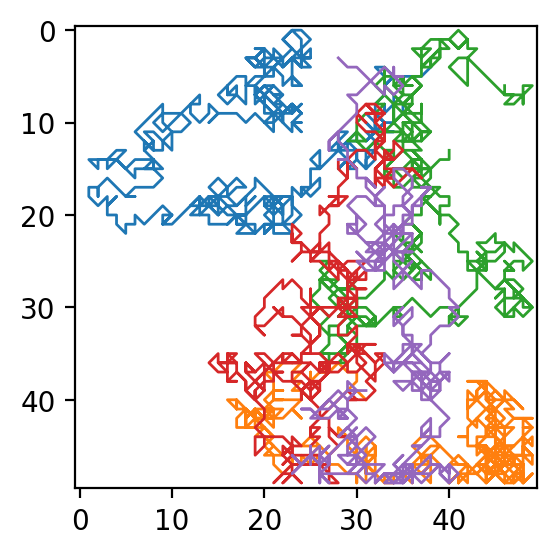

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Setup
# -----------------------------
rng = np.random.default_rng(42)

H, W = 50, 50
num_episodes = 5
walk_len = 500

# -----------------------------
# Reflecting step
# -----------------------------
def step_reflect(r, c, dr, dc, H, W):
    nr, nc = r + dr, c + dc
    if nr < 0: nr = -nr
    if nr >= H: nr = 2*H - nr - 2
    if nc < 0: nc = -nc
    if nc < 0: nc = -nc
    if nc >= W: nc = 2*W - nc - 2
    return nr, nc

# -----------------------------
# 8-neighbor moves
# -----------------------------
moves8 = np.array([
    (-1,-1), (-1,0), (-1,1),
    ( 0,-1),          ( 0,1),
    ( 1,-1), ( 1,0),  ( 1,1)
], dtype=int)

# -----------------------------
# Generate trajectories
# -----------------------------
paths = []

for _ in range(num_episodes):
    r = rng.integers(0, H)
    c = rng.integers(0, W)

    path = [(r, c)]

    for _ in range(walk_len):
        dr, dc = moves8[rng.integers(0, len(moves8))]
        r, c = step_reflect(r, c, dr, dc, H, W)
        path.append((r, c))

    paths.append(path)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(3, 3),dpi=200)

for path in paths:
    p = np.array(path)
    ax.plot(p[:, 1], p[:, 0], linewidth=1)

ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_aspect("equal")

plt.show()


In [2]:
import math

def approximate_circle_points(
    N,
    center=(24, 24),
    radius=None,
    grid_size=50,
    oversample_factor=4,
):
    """
    Return N integer lattice points that approximate a circle on a grid.

    Parameters
    ----------
    N : int
        Number of points to generate.
    center : tuple(int, int)
        Center of the circle (cx, cy).
    radius : float or None
        Circle radius. If None, choose the largest radius that stays inside [0, grid_size-1]
        with a 1-cell padding from the border.
    grid_size : int
        Playground is 0..grid_size-1 in both x and y.
    oversample_factor : int
        How many more angles to sample than N (helps reduce duplicates after rounding).

    Returns
    -------
    points : list of (int, int)
        List of N lattice points approximately forming a circle.
    """
    cx, cy = center

    # Auto-choose a radius if not provided
    if radius is None:
        max_r = min(cx, cy, grid_size - 1 - cx, grid_size - 1 - cy)
        radius = max_r - 1  # leave 1-cell padding

    # Oversample on the circle to compensate for rounding collisions
    M = max(N * oversample_factor, N)
    seen = set()
    unique_points = []

    for k in range(M):
        theta = 2 * math.pi * k / M - math.pi/6
        x = int(round(cx + radius * math.cos(theta)))
        y = int(round(cy + radius * math.sin(theta)))

        if 0 <= x < grid_size and 0 <= y < grid_size:
            if (x, y) not in seen:
                seen.add((x, y))
                unique_points.append((x, y))

    if len(unique_points) == 0:
        raise RuntimeError("No valid points were generated. Check center/radius/grid_size.")

    if len(unique_points) < N:
        # You are asking for more distinct integer points than exist on this discrete circle
        raise ValueError(
            f"Only {len(unique_points)} distinct lattice points lie on this circle "
            f"with radius={radius}, but N={N} was requested."
        )

    # Pick N roughly evenly spaced points along the generated circle
    points = []
    stride = len(unique_points) / N
    for i in range(N):
        idx = int(round(i * stride)) % len(unique_points)
        points.append(unique_points[idx])

    return points


# Example usage in a 50x50 playground:
if __name__ == "__main__":
    N = 4
    pts = approximate_circle_points(N, center=(24, 24), radius = 10, grid_size=50)
    print("Circle points:")
    for p in pts:
        print(p)


Circle points:
(33, 19)
(29, 33)
(15, 29)
(19, 15)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

rng = np.random.default_rng(0)

H, W = 50, 50
N_PIX = H * W

num_episodes = 100000
walk_len = 500

start = (24, 24)
N = 4
pts = approximate_circle_points(N, center=(24, 24), radius=15, grid_size=50)
goals_init = pts

# -----------------------------
# Reflecting step
# -----------------------------
def step_reflect(r, c, dr, dc, H, W):
    nr, nc = r + dr, c + dc
    if nr < 0: nr = -nr
    if nr >= H: nr = 2*H - nr - 2
    if nc < 0: nc = -nc
    if nc >= W: nc = 2*W - nc - 2
    return nr, nc

# -----------------------------
# 8-neighbor training moves
# -----------------------------
neighbors8 = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),          ( 0,1),
              ( 1,-1), ( 1,0),  ( 1,1)]
moves8 = np.array(neighbors8, dtype=int)

visited = np.zeros((N_PIX, num_episodes), dtype=bool)

 # store only paths that visit both A and B

def rc_to_idx(rc): return rc[0]*W + rc[1]

for e in tqdm(range(num_episodes), desc="training (8-neigh)"):
    r = rng.integers(0, H)
    c = rng.integers(0, W)

    mask = np.zeros((H, W), dtype=bool)
    mask[r, c] = True


    path = [(r, c)]

    for _ in range(walk_len):
        dr, dc = moves8[rng.integers(0, len(moves8))]
        r, c = step_reflect(r, c, dr, dc, H, W)
        mask[r, c] = True

        path.append((r, c))

    visited[:, e] = mask.reshape(-1)


training (8-neigh):   0%|          | 0/100000 [00:00<?, ?it/s]

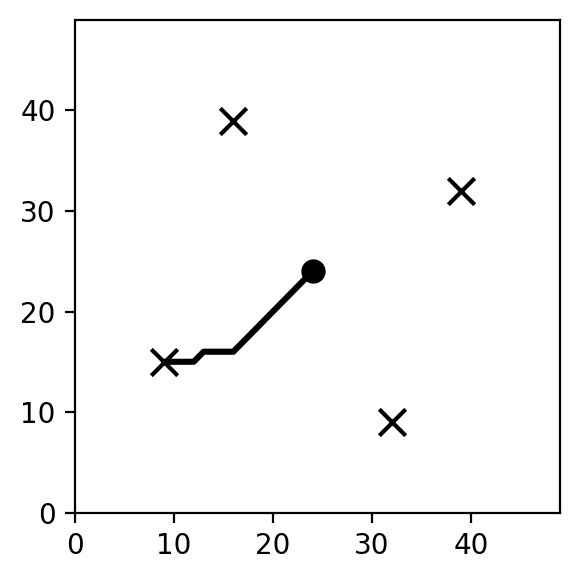

In [4]:
# Multi-goal greedy navigation with removal: after reaching one goal, remove it and
# continue to the remaining goal. Background: 50x50 grid, 10,000 episodes.
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Reproducibility
rng = np.random.default_rng(42)

H, W = 50, 50
N_PIX = H * W



start = (24, 24)
N = 4
pts = approximate_circle_points(N, center=(24, 24), radius = 17, grid_size=50)
goals_init = pts#[(15, 15), (35, 15)]

# -----------------------------
# Episode sampling (reflecting)
# -----------------------------
def step_reflect(r, c, dr, dc, H, W):
    nr, nc = r + dr, c + dc
    if nr < 0: nr = -nr
    if nr >= H: nr = 2*H - nr - 2
    if nc < 0: nc = -nc
    if nc >= W: nc = 2*W - nc - 2
    return nr, nc


def rc_to_idx(rc): return rc[0]*W + rc[1]

def make_scores(active_goals):
    """Co-occurrence counts with the union over currently active goals."""
    union = np.zeros(num_episodes, dtype=bool)
    for g in active_goals:
        union |= visited[rc_to_idx(g), :]
    return (visited & union[np.newaxis, :]).sum(axis=1).reshape(H, W)

# ----------------------------------
# Greedy 8-neighbor path to nearest active goal
# ----------------------------------
neighbors8 = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),          ( 0,1),
              ( 1,-1), ( 1,0),  ( 1,1)]


def in_bounds(r,c): return 0 <= r < H and 0 <= c < W

def dist2_to_nearest_goal(r,c,goals):
    return min((r-gr)**2 + (c-gc)**2 for gr,gc in goals)


def greedy_path(
    start, active_goals, scores, max_steps=500
):
    r, c = start
    path = [(r, c)]
    visited = set([(r, c)])
    goals_set = set(active_goals)

    for _ in range(max_steps):
        if (r, c) in goals_set:
            break

        best = None
        best_score = -np.inf

        for dr, dc in neighbors8:
            nr, nc = r + dr, c + dc
            if not in_bounds(nr, nc):
                continue
            if (nr, nc) in visited:
                continue  # HARD no-revisit constraint

            s = scores[nr, nc]
            if s > best_score:
                best_score = s
                best = (nr, nc)

        if best is None:
            break  # dead end

        r, c = best
        path.append((r, c))
        visited.add((r, c))

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached
# Stage 1: both goals active
scores_both = make_scores(goals_init)
path1, reached1 = greedy_path(start, goals_init, scores_both, max_steps=500)

# ------------------
# Plot & save figure
# ------------------
plt.figure(figsize=(3,3),dpi=200)

# Overlay first leg
r1, c1 = zip(*path1)
plt.plot(c1, r1,'-', linewidth=2.2,c='black')

plt.xlim(0,49)
plt.ylim(0,49)

# plt.xlabel("Column")
# plt.ylabel("Row")

plt.scatter([start[1]],[start[0]], s=60, marker='o',c='black')  # start
for g in goals_init:
    plt.scatter([g[1]],[g[0]], s=90, marker='x',c='black')      # initial goals
# Reached points
# if reached1 is not None:
#     plt.scatter([reached1[1]],[reached1[0]], s=70, marker='o', edgecolors='black')


plt.tight_layout()



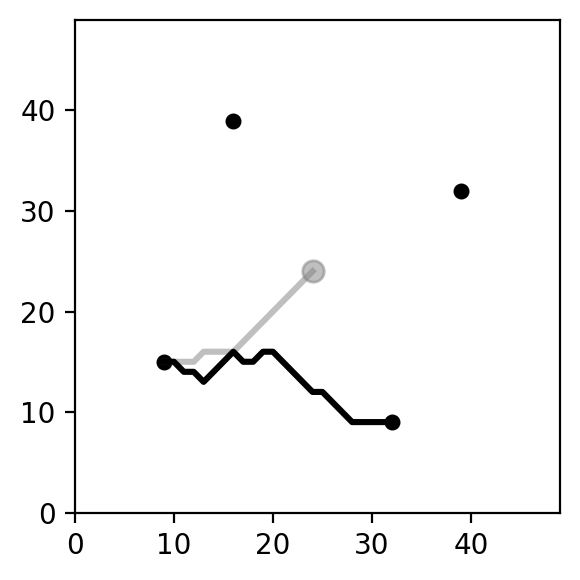

In [5]:
path0=path1

# Multi-goal greedy navigation with removal: after reaching one goal, remove it and
# continue to the remaining goal. Background: 50x50 grid, 10,000 episodes.
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Reproducibility
rng = np.random.default_rng(42)

H, W = 50, 50
N_PIX = H * W



start = (15, 9)
N = 4
goals_init = [(39, 16), (32, 39), (9, 32)]#[(15, 15), (35, 15)]

# -----------------------------
# Episode sampling (reflecting)
# -----------------------------
def step_reflect(r, c, dr, dc, H, W):
    nr, nc = r + dr, c + dc
    if nr < 0: nr = -nr
    if nr >= H: nr = 2*H - nr - 2
    if nc < 0: nc = -nc
    if nc >= W: nc = 2*W - nc - 2
    return nr, nc


def rc_to_idx(rc): return rc[0]*W + rc[1]

def make_scores(active_goals):
    """Co-occurrence counts with the union over currently active goals."""
    union = np.zeros(num_episodes, dtype=bool)
    for g in active_goals:
        union |= visited[rc_to_idx(g), :]
    return (visited & union[np.newaxis, :]).sum(axis=1).reshape(H, W)

# ----------------------------------
# Greedy 8-neighbor path to nearest active goal
# ----------------------------------
neighbors8 = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),          ( 0,1),
              ( 1,-1), ( 1,0),  ( 1,1)]


def in_bounds(r,c): return 0 <= r < H and 0 <= c < W

def dist2_to_nearest_goal(r,c,goals):
    return min((r-gr)**2 + (c-gc)**2 for gr,gc in goals)


def greedy_path(
    start, active_goals, scores, max_steps=500
):
    r, c = start
    path = [(r, c)]
    visited = set([(r, c)])
    goals_set = set(active_goals)

    for _ in range(max_steps):
        if (r, c) in goals_set:
            break

        best = None
        best_score = -np.inf

        for dr, dc in neighbors8:
            nr, nc = r + dr, c + dc
            if not in_bounds(nr, nc):
                continue
            if (nr, nc) in visited:
                continue  # HARD no-revisit constraint

            s = scores[nr, nc]
            if s > best_score:
                best_score = s
                best = (nr, nc)

        if best is None:
            break  # dead end

        r, c = best
        path.append((r, c))
        visited.add((r, c))

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached
# Stage 1: both goals active
scores_both = make_scores(goals_init)
path1, reached1 = greedy_path(start, goals_init, scores_both, max_steps=500)

# ------------------
# Plot & save figure
# ------------------
plt.figure(figsize=(3,3),dpi=200)

# Overlay first leg
r0, c0 = zip(*path0)
plt.plot(c0, r0,'-', linewidth=2.2,c='gray',alpha=.5)

r1, c1 = zip(*path1)
plt.plot(c1, r1,'-', linewidth=2.2,c='black')

plt.xlim(0,49)
plt.ylim(0,49)

# plt.xlabel("Column")
# plt.ylabel("Row")

plt.scatter([24],[24], s=60, marker='o',c='gray',alpha=.5)  # start
for g in pts:
    plt.scatter([g[1]],[g[0]], s=90, marker='.',c='black')      # initial goals
# Reached points
# if reached1 is not None:
#     plt.scatter([reached1[1]],[reached1[0]], s=70, marker='o', edgecolors='black')


plt.tight_layout()



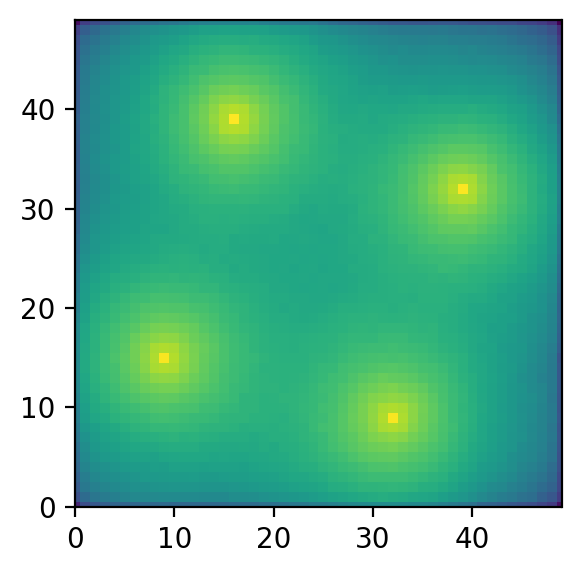

In [6]:
# Multi-goal greedy navigation with removal: after reaching one goal, remove it and
# continue to the remaining goal. Background: 50x50 grid, 10,000 episodes.
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Reproducibility
rng = np.random.default_rng(42)

H, W = 50, 50
N_PIX = H * W



start = (24, 24)
N = 4
pts = approximate_circle_points(N, center=(24, 24), radius = 17, grid_size=50)
goals_init = pts#[(15, 15), (35, 15)]

# -----------------------------
# Episode sampling (reflecting)
# -----------------------------
def step_reflect(r, c, dr, dc, H, W):
    nr, nc = r + dr, c + dc
    if nr < 0: nr = -nr
    if nr >= H: nr = 2*H - nr - 2
    if nc < 0: nc = -nc
    if nc >= W: nc = 2*W - nc - 2
    return nr, nc


def rc_to_idx(rc): return rc[0]*W + rc[1]

def make_scores(active_goals):
    """Co-occurrence counts with the union over currently active goals."""
    union = np.zeros(num_episodes, dtype=bool)
    for g in active_goals:
        union |= visited[rc_to_idx(g), :]
    return (visited & union[np.newaxis, :]).sum(axis=1).reshape(H, W)

# ----------------------------------
# Greedy 8-neighbor path to nearest active goal
# ----------------------------------
neighbors8 = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),          ( 0,1),
              ( 1,-1), ( 1,0),  ( 1,1)]


def in_bounds(r,c): return 0 <= r < H and 0 <= c < W

def dist2_to_nearest_goal(r,c,goals):
    return min((r-gr)**2 + (c-gc)**2 for gr,gc in goals)


def greedy_path(
    start, active_goals, scores, max_steps=500
):
    r, c = start
    path = [(r, c)]
    visited = set([(r, c)])
    goals_set = set(active_goals)

    for _ in range(max_steps):
        if (r, c) in goals_set:
            break

        best = None
        best_score = -np.inf

        for dr, dc in neighbors8:
            nr, nc = r + dr, c + dc
            if not in_bounds(nr, nc):
                continue
            if (nr, nc) in visited:
                continue  # HARD no-revisit constraint

            s = scores[nr, nc]
            if s > best_score:
                best_score = s
                best = (nr, nc)

        if best is None:
            break  # dead end

        r, c = best
        path.append((r, c))
        visited.add((r, c))

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached

    reached = (r, c) if (r, c) in goals_set else None
    return path, reached
# Stage 1: both goals active
scores_both = make_scores(goals_init)
path1, reached1 = greedy_path(start, goals_init, scores_both, max_steps=500)

# ------------------
# Plot & save figure
# ------------------
plt.figure(figsize=(3,3),dpi=200)
im = plt.imshow(np.log(scores_both), origin="lower", interpolation="nearest")
# Overlay first leg
r1, c1 = zip(*path1)
# plt.plot(c1, r1, linewidth=2.2,c='red')

plt.xlim(0,49)
plt.ylim(0,49)

# plt.xlabel("Column")
# plt.ylabel("Row")

# plt.scatter([start[1]],[start[0]], s=60, marker='o',c='black')  # start
# for g in goals_init:
#     plt.scatter([g[1]],[g[0]], s=10, marker='x',c='black')      # initial goals
# Reached points
# if reached1 is not None:
#     plt.scatter([reached1[1]],[reached1[0]], s=70, marker='o', edgecolors='black')


plt.tight_layout()

